# Housing Market Challenge

In [59]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [60]:
houses_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [61]:
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [62]:
houses_df.isnull().sum()

id                  0
mssubclass          0
mszoning            0
lotfrontage       259
lotarea             0
street              0
alley            1369
lotshape            0
landcontour         0
utilities           0
lotconfig           0
landslope           0
neighborhood        0
condition1          0
condition2          0
bldgtype            0
housestyle          0
overallqual         0
overallcond         0
yearbuilt           0
yearremodadd        0
roofstyle           0
roofmatl            0
exterior1st         0
exterior2nd         0
masvnrtype          8
masvnrarea          8
exterqual           0
extercond           0
foundation          0
                 ... 
bedroomabvgr        0
kitchenabvgr        0
kitchenqual         0
totrmsabvgrd        0
functional          0
fireplaces          0
fireplacequ       690
garagetype         81
garageyrblt        81
garagefinish       81
garagecars          0
garagearea          0
garagequal         81
garagecond         81
paveddrive

In [63]:
# These are columns with missing values in data frame we need to analyze
houses_df.columns[houses_df.isnull().any()]

Index(['lotfrontage', 'alley', 'masvnrtype', 'masvnrarea', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'electrical', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagequal', 'garagecond', 'poolqc', 'fence',
       'miscfeature'],
      dtype='object')

In [64]:
#We can see the masonry veneer type and area are both equal 8 times in the same rows, so we will replace them with 'None' and '0' values respectively.
houses_df['masvnrtype'] = houses_df['masvnrtype'].fillna('None')
houses_df['masvnrarea'] = houses_df['masvnrarea'].fillna(0)

#Replacing Nan values in Alley to a string stating 'No Alley'
houses_df['alley'] = houses_df['alley'].fillna('No Alley')

#Replacing Nan values in all basement columns to string 'No Basement'
houses_df['bsmtqual'] = houses_df['bsmtqual'].fillna('No Basement')
houses_df['bsmtcond'] = houses_df['bsmtcond'].fillna('No Basement')
houses_df['bsmtexposure'] = houses_df['bsmtexposure'].fillna('No Basement')
houses_df['bsmtfintype1'] = houses_df['bsmtfintype1'].fillna('No Basement')
houses_df['bsmtfintype2'] = houses_df['bsmtfintype2'].fillna('No Basement')

#Only one missing value in Electrical, replacing it with Mixed
houses_df['electrical'] = houses_df['electrical'].fillna('Mix')

#Replacing fireplace quality missing values with NF - No Fireplace
houses_df['fireplacequ'] = houses_df['fireplacequ'].fillna('NF')

#Replacing Garage missing values with NG - No Garage.
houses_df['garagetype'] = houses_df['garagetype'].fillna('NG')
houses_df['garagefinish'] = houses_df['garagefinish'].fillna('NG')
houses_df['garagequal'] = houses_df['garagequal'].fillna('NG')
houses_df['garagecond'] = houses_df['garagecond'].fillna('NG')

#Replacing pool missing values with NP - no pool
houses_df['poolqc'] = houses_df['poolqc'].fillna('NP')

#Replacing fence missing val with NF - no fence
houses_df['fence'] = houses_df['fence'].fillna('NF')

#Replacing misc feature missing value with 'Nothing'
houses_df['miscfeature'] = houses_df['miscfeature'].fillna('Nothing')

#These are the columns I have decided it makes sense to replace missing values with the mean of the columns
houses_df['lotfrontage'].fillna(houses_df['lotfrontage'].mean(),inplace=True)
houses_df['garageyrblt'].fillna(houses_df['garageyrblt'].mean(),inplace=True)

In [65]:
# Check to see if any missing values remain
houses_df.columns[houses_df.isnull().any()]

Index([], dtype='object')

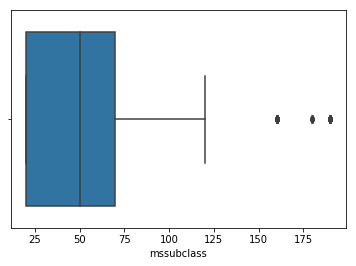

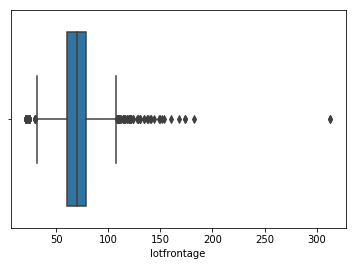

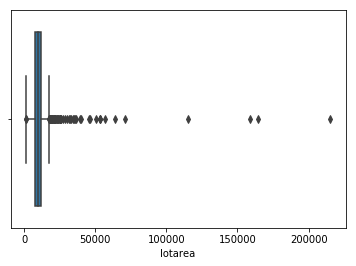

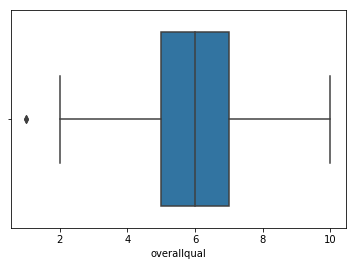

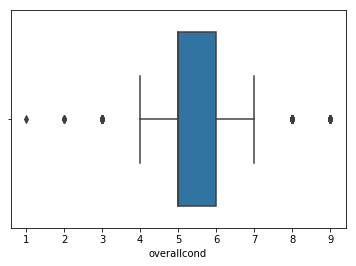

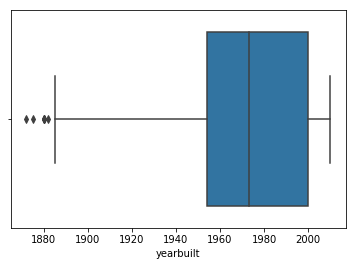

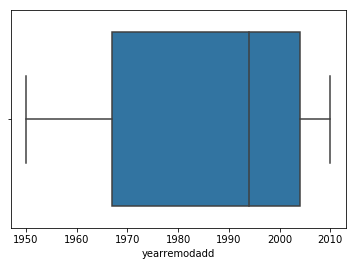

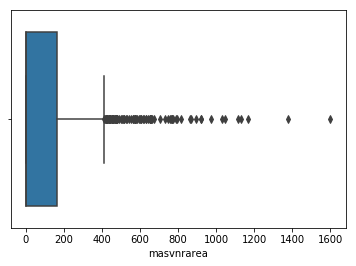

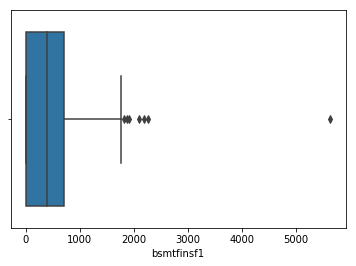

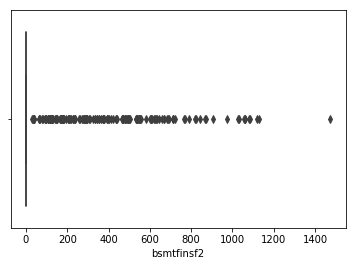

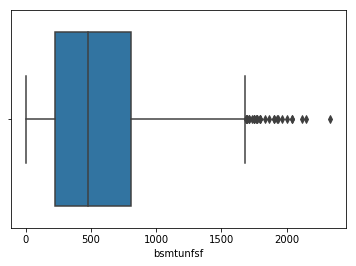

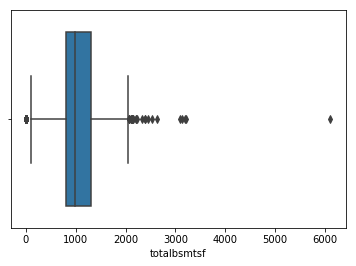

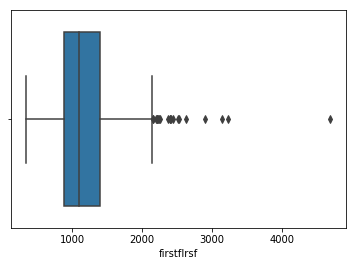

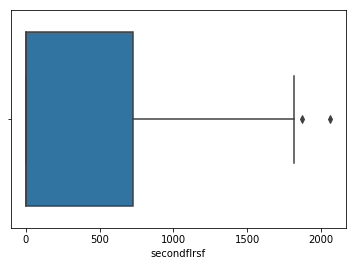

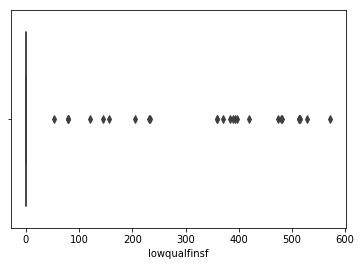

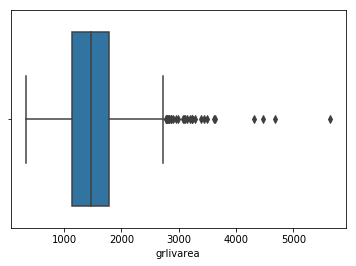

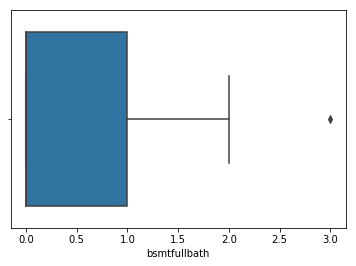

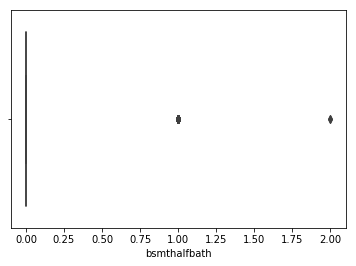

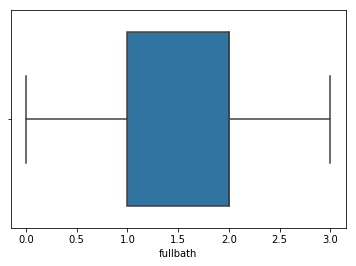

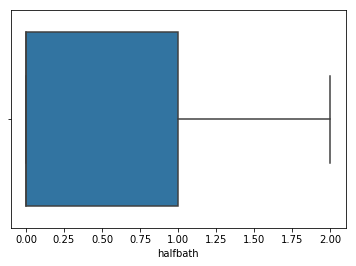

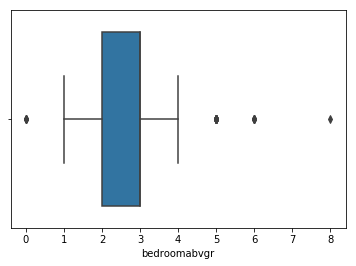

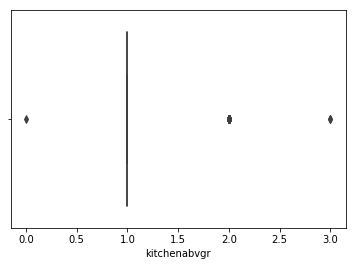

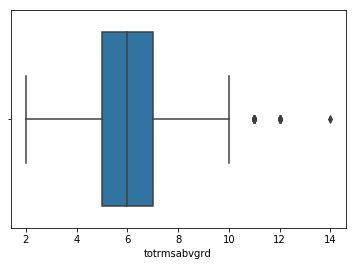

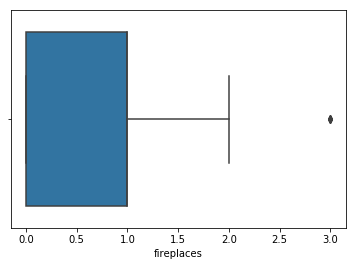

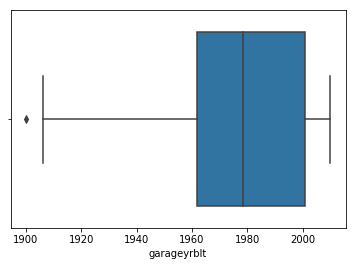

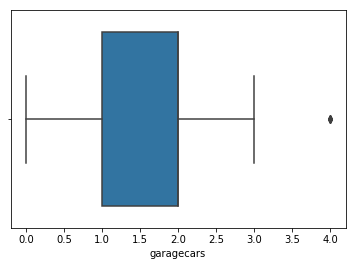

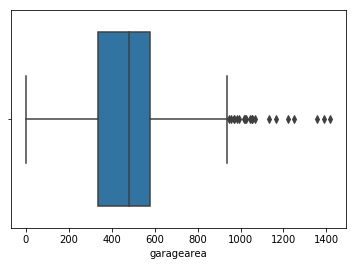

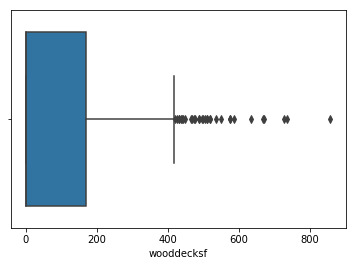

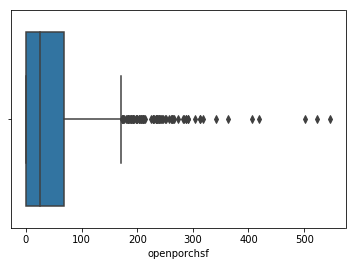

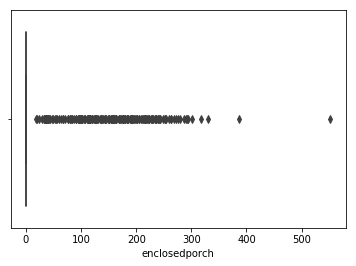

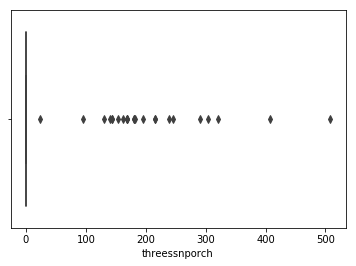

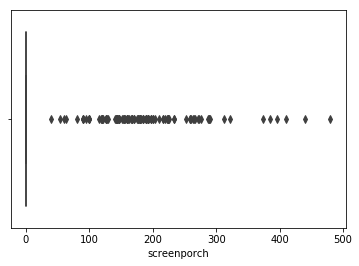

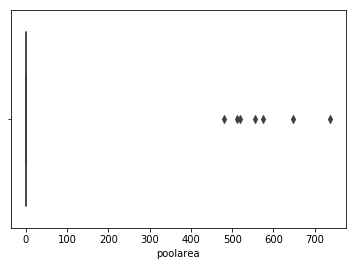

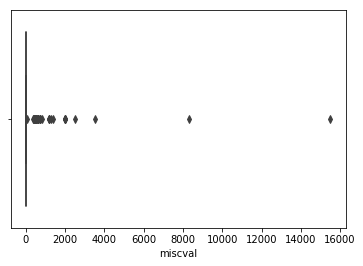

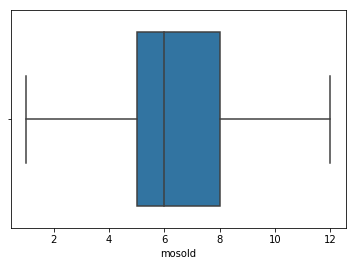

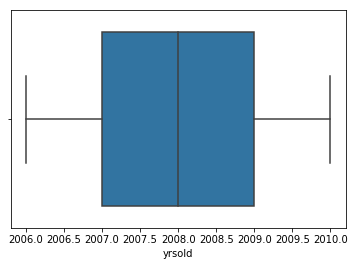

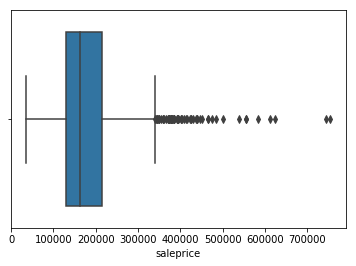

In [66]:
# Explore the numerical columns to check for outliers

columns = ['mssubclass',       
'lotfrontage',      
'lotarea',          
'overallqual',      
'overallcond',      
'yearbuilt',        
'yearremodadd',     
'masvnrarea',
'bsmtfinsf1', 
'bsmtfinsf2', 
'bsmtunfsf',
'totalbsmtsf',
'firstflrsf', 
'secondflrsf',
'lowqualfinsf',
'grlivarea',
'bsmtfullbath',
'bsmthalfbath',
'fullbath',
'halfbath',
'bedroomabvgr',
'kitchenabvgr',
'totrmsabvgrd',
'fireplaces',
'garageyrblt',
'garagecars',
'garagearea',
'wooddecksf',
'openporchsf',
'enclosedporch',
'threessnporch',
'screenporch',
'poolarea',
'miscval',
'mosold',
'yrsold',
'saleprice']

for column in columns:
    sns.boxplot(houses_df[column])
    plt.show()

While the boxplots appear to show some outliers, none of the values appear to be nonsensical and I don't believe winsorization or other outlier methods are necessary.

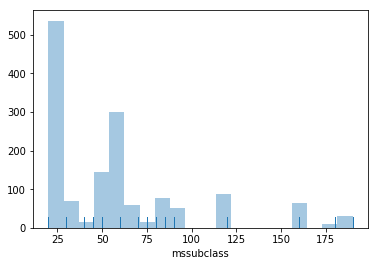

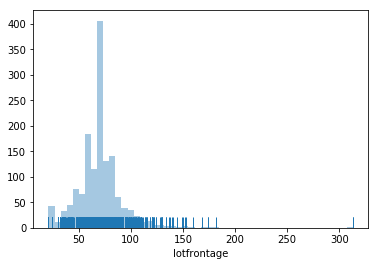

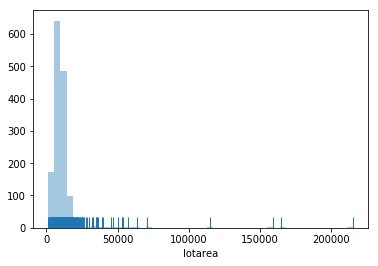

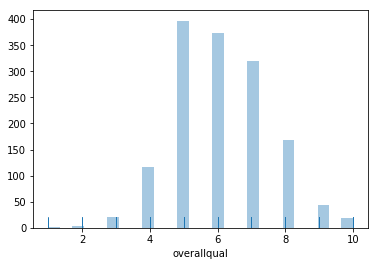

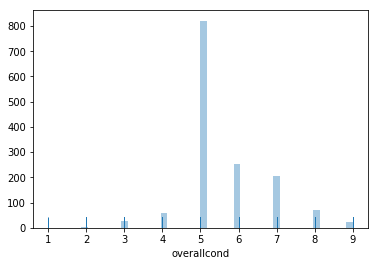

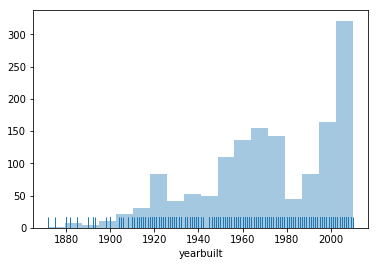

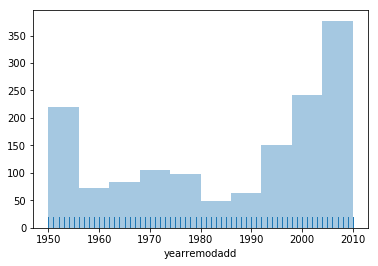

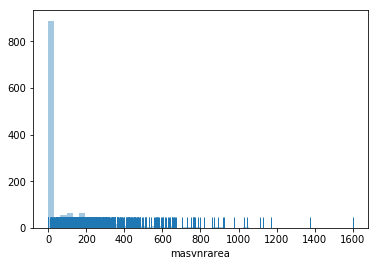

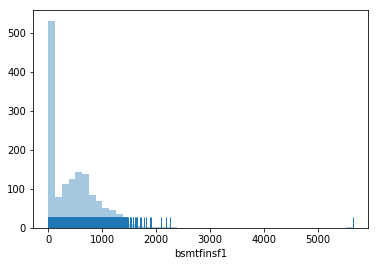

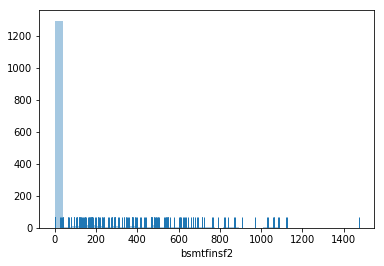

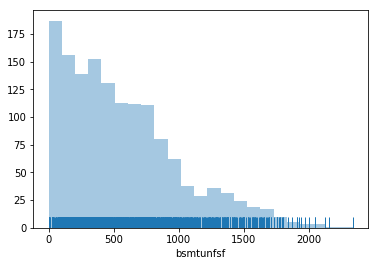

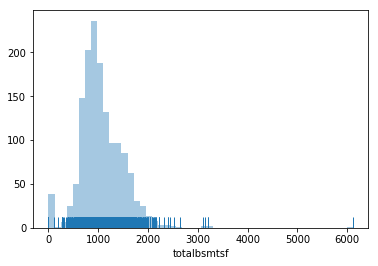

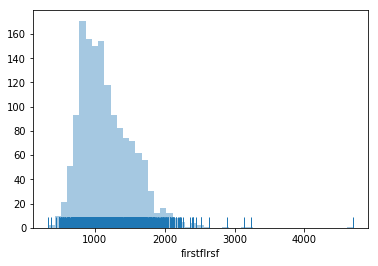

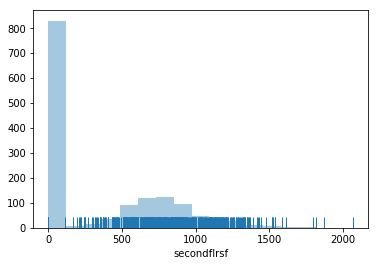

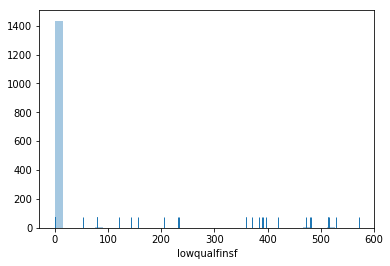

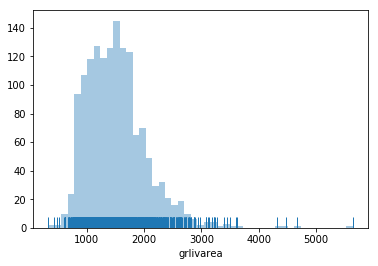

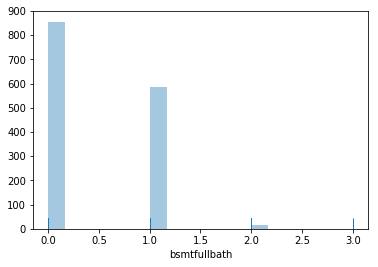

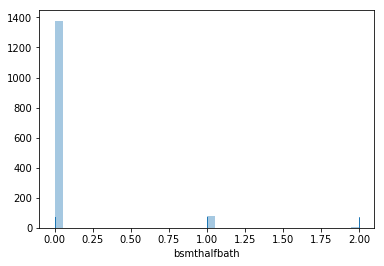

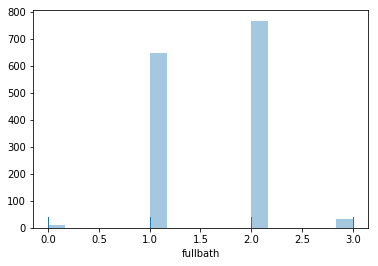

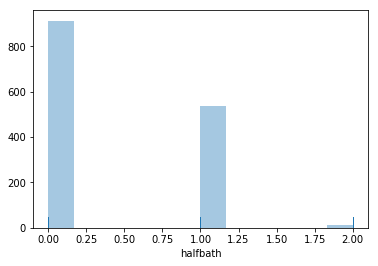

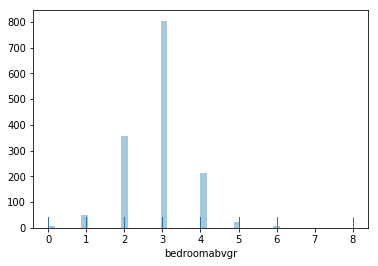

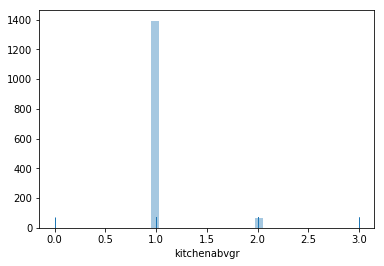

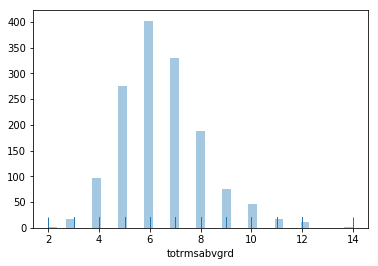

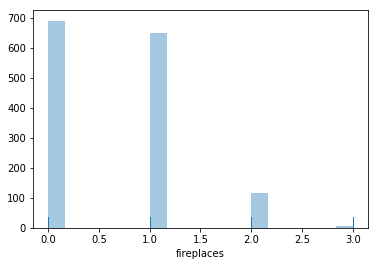

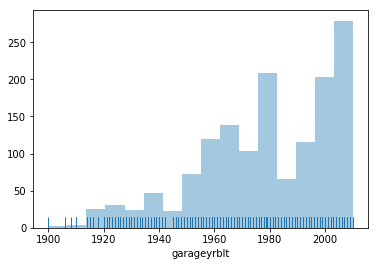

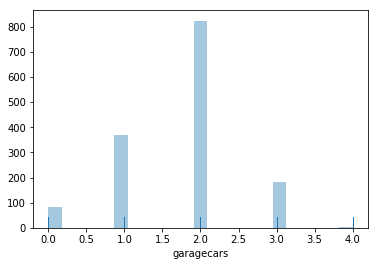

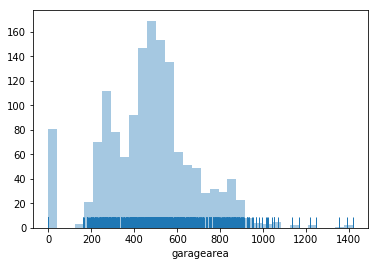

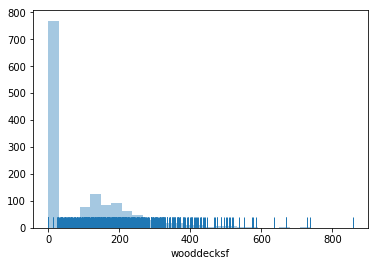

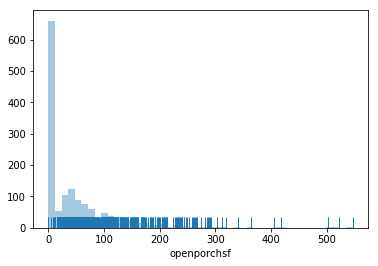

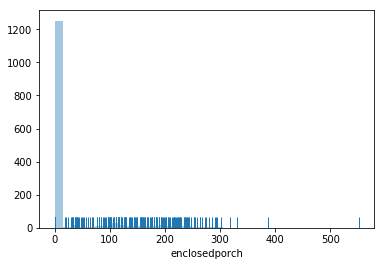

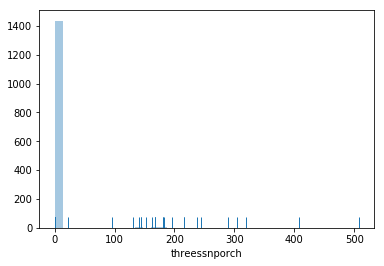

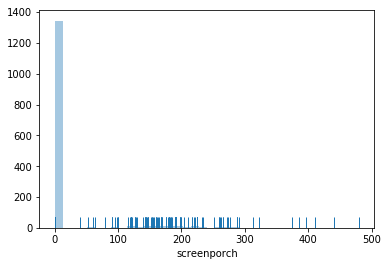

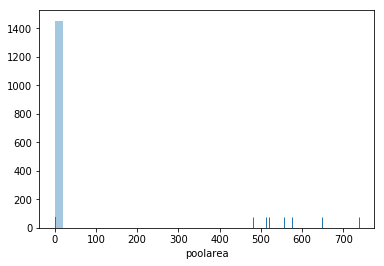

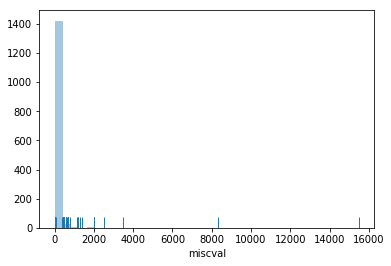

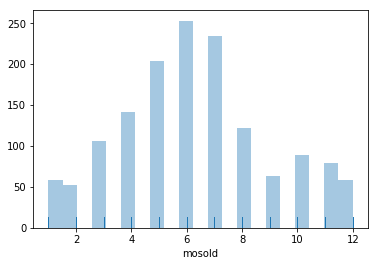

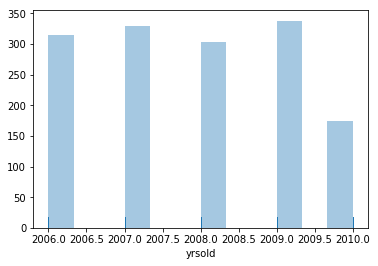

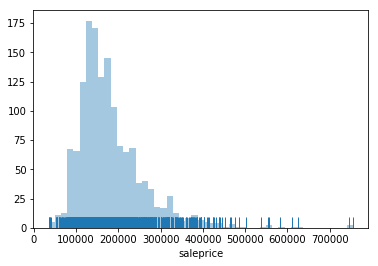

In [67]:
# Data Exploration

for column in columns:
    sns.distplot(houses_df[column],kde=False, rug=True)
    plt.show()

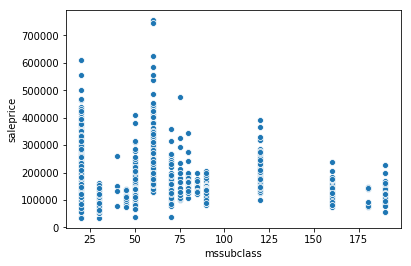

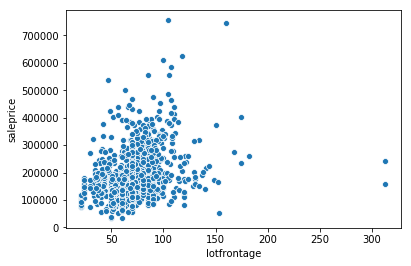

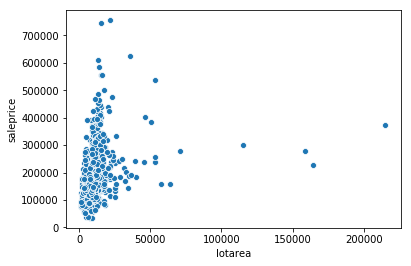

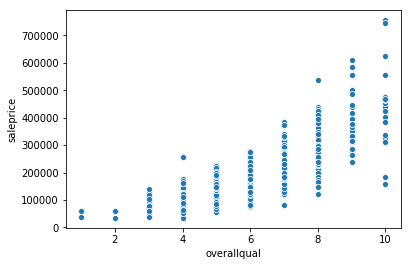

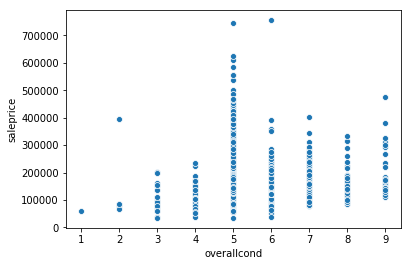

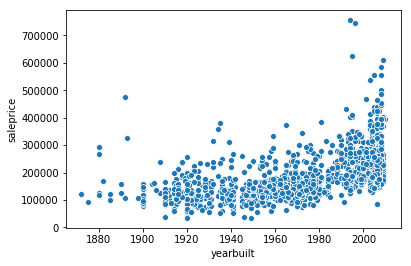

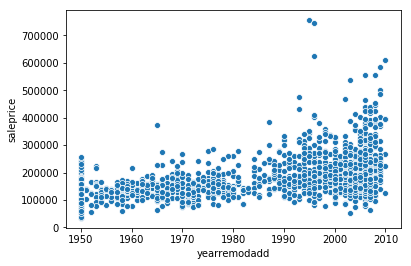

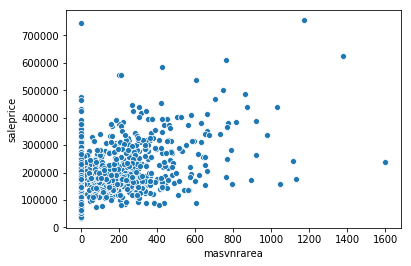

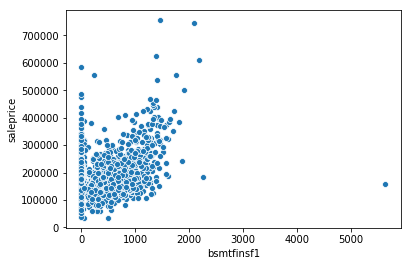

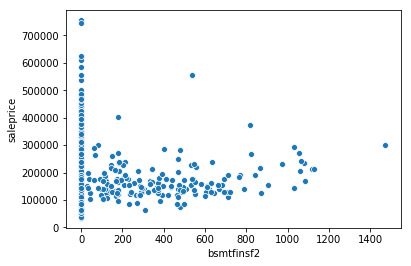

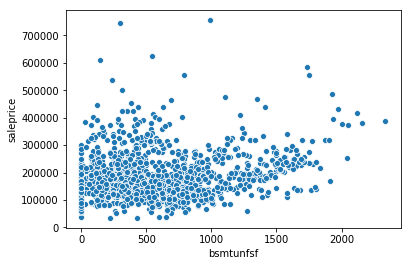

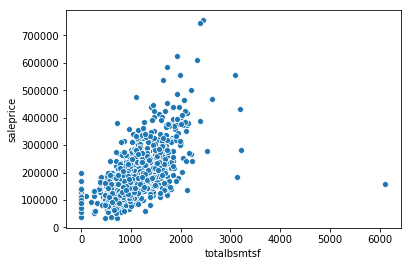

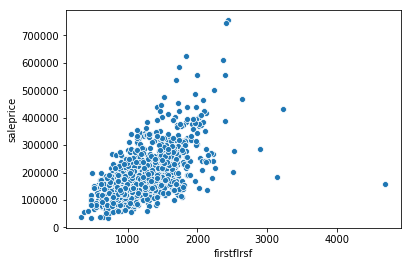

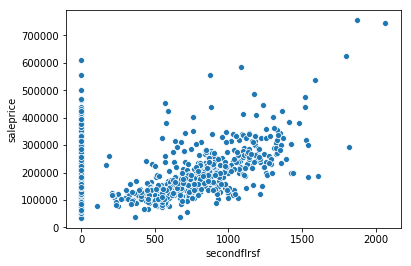

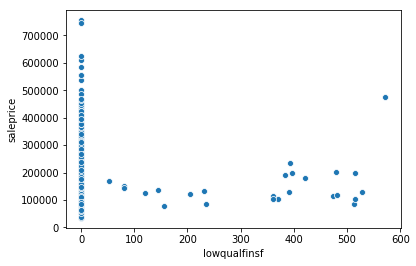

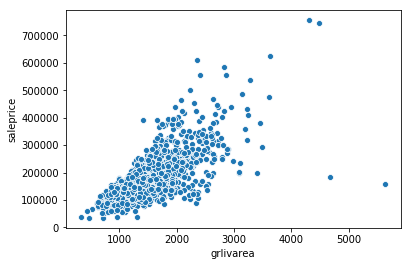

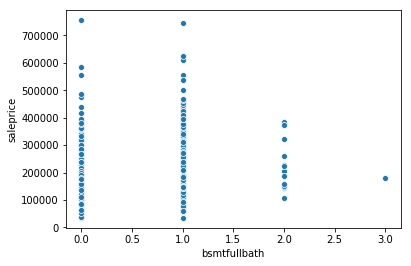

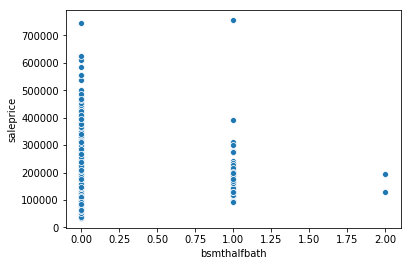

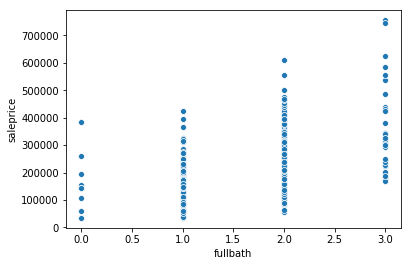

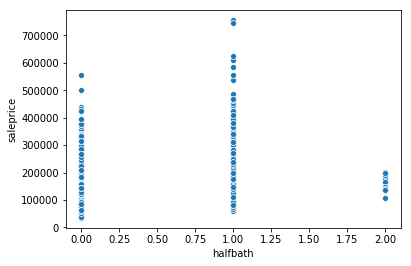

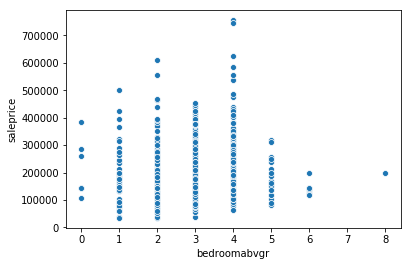

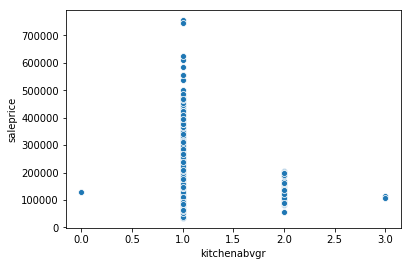

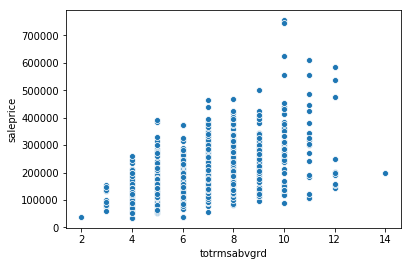

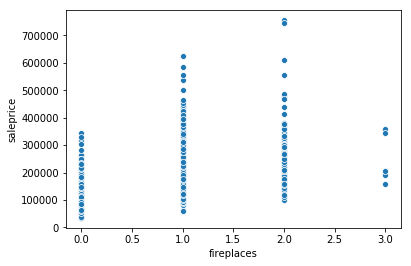

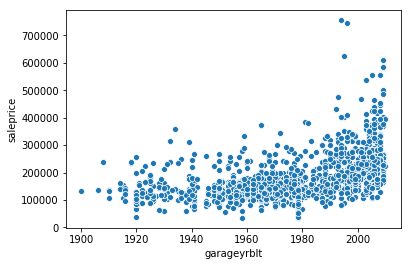

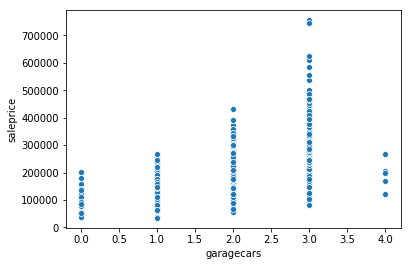

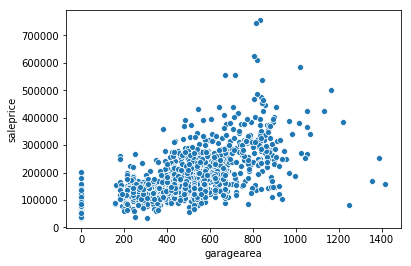

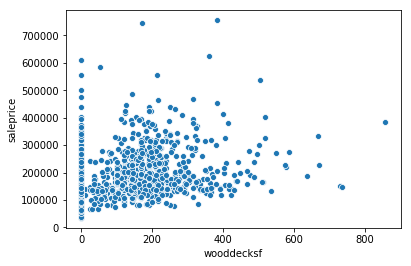

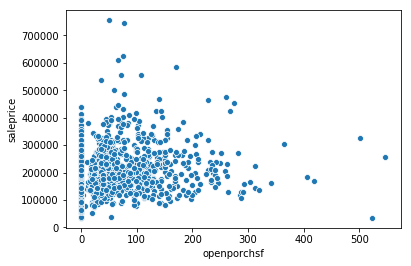

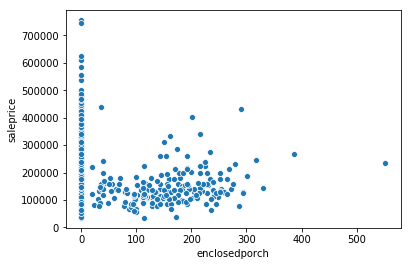

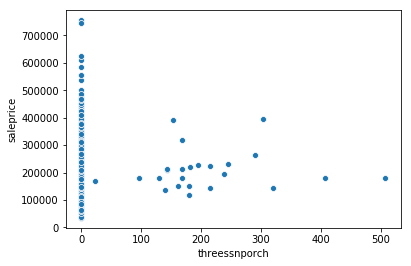

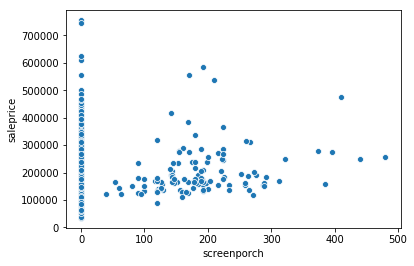

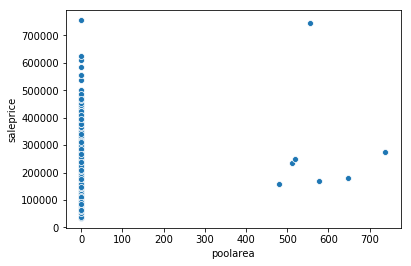

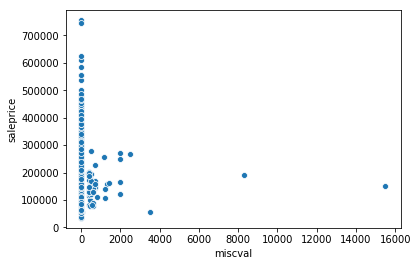

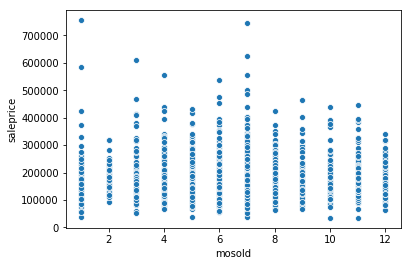

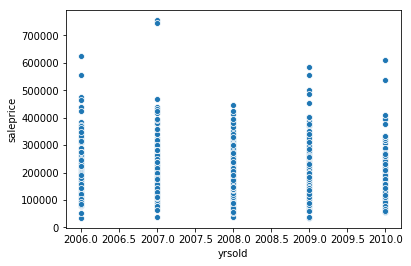

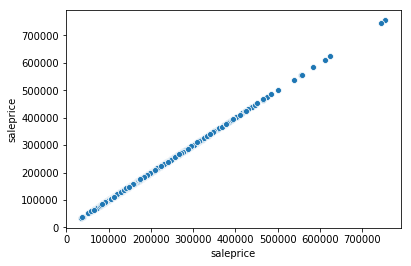

In [68]:
#Inspect the relationship between variables and target variable 'saleprice'
for column in columns:
    sns.scatterplot(houses_df[column], houses_df['saleprice'])
    plt.show()

In [69]:
houses_df.corr()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
id,1.000000,0.011156,-0.009601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.051071,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
mssubclass,0.011156,1.000000,-0.357056,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
lotfrontage,-0.009601,-0.357056,1.000000,0.306795,0.234196,-0.052820,0.117598,0.082746,0.178699,0.215828,...,0.077106,0.137454,0.009790,0.062335,0.037684,0.180868,0.001168,0.010158,0.006768,0.334901
lotarea,-0.033226,-0.139781,0.306795,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
overallqual,-0.028365,0.032628,0.234196,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
overallcond,0.012609,-0.059316,-0.052820,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
yearbuilt,-0.012713,0.027850,0.117598,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
yearremodadd,-0.021998,0.040581,0.082746,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
masvnrarea,-0.051071,0.023573,0.178699,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,...,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,-0.029512,-0.006723,-0.008317,0.472614
bsmtfinsf1,-0.005024,-0.069836,0.215828,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


Variables most correlated to saleprice are the Square foot variables, Garage variables, and overall quality. These will be the variables we will proceed forward with in the feature engineering section.

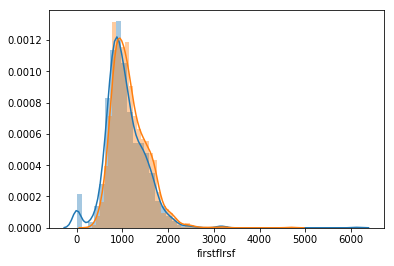

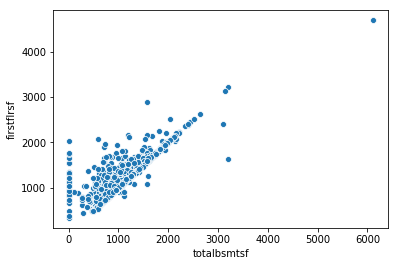

In [70]:
#Intuition tells us that there is probably a relationship with first floor SF and basement SF. Let's plot the distributions to see if they are similar.
sns.distplot(houses_df['totalbsmtsf'])
sns.distplot(houses_df['firstflrsf'])
plt.show()

sns.scatterplot(x=houses_df['totalbsmtsf'],y=houses_df['firstflrsf'])
plt.show()

In [71]:
#It does appear the variables are similar in distribution and we will combine them to make a new variable.
houses_df['firstandbsmtsf'] = houses_df['totalbsmtsf'] + houses_df['firstflrsf']

In [72]:
import statsmodels.api as sm
X = houses_df[['overallqual','firstandbsmtsf','grlivarea','garagecars','garagearea']]
Y = houses_df['saleprice']
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

#split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

Ridge_regr = RidgeCV(alphas=[0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]).fit(X_train, y_train)
Lasso_regr = LassoCV(alphas=[0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]).fit(X_train, y_train)
EN_regr = ElasticNetCV(alphas=[0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]).fit(X_train, y_train)


In [73]:
# We are making predictions here
y_preds_train = Ridge_regr.predict(X_train)
y_preds_test = Ridge_regr.predict(X_test)
print("Best alpha value is: {}".format(Ridge_regr.alpha_))
print("R-squared of the model in the training set is: {}".format(Ridge_regr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(Ridge_regr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


Best alpha value is: 10.0
R-squared of the model in the training set is: 0.7597867629708688
-----Test set statistics-----
R-squared of the model in the test set is: 0.7652024167520093
Mean absolute error of the prediction is: 26084.265358316596
Mean squared error of the prediction is: 1576361492.4086158
Root mean squared error of the prediction is: 39703.41915261979
Mean absolute percentage error of the prediction is: 16.1548463610854


In [74]:
# We are making predictions here
y_preds_train = Lasso_regr.predict(X_train)
y_preds_test = Lasso_regr.predict(X_test)
print("Best alpha value is: {}".format(Lasso_regr.alpha_))
print("R-squared of the model in the training set is: {}".format(Lasso_regr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(Lasso_regr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


Best alpha value is: 0.1
R-squared of the model in the training set is: 0.7598093751409853
-----Test set statistics-----
R-squared of the model in the test set is: 0.7648187868294307
Mean absolute error of the prediction is: 26160.89969071476
Mean squared error of the prediction is: 1578937070.1846864
Root mean squared error of the prediction is: 39735.841128440785
Mean absolute percentage error of the prediction is: 16.213986813477284


In [75]:
# We are making predictions here
y_preds_train = EN_regr.predict(X_train)
y_preds_test = EN_regr.predict(X_test)
print("Best alpha value is: {}".format(EN_regr.alpha_))
print("R-squared of the model in the training set is: {}".format(EN_regr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(EN_regr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


Best alpha value is: 0.1
R-squared of the model in the training set is: 0.7592823643551059
-----Test set statistics-----
R-squared of the model in the test set is: 0.7664976050765067
Mean absolute error of the prediction is: 25816.324732829893
Mean squared error of the prediction is: 1567665981.2712696
Root mean squared error of the prediction is: 39593.7618984515
Mean absolute percentage error of the prediction is: 15.938439596134724


The best performance of the 3 different models was the modeling using Elastic Net Regression. The 3 models were, however, very similar in performance with the adjusted R-squared of each model varying by 0.1 or less. 

I can definitely see the value in adding in more variables to the model such as interest rates or economic activity, as I expect these variables would correlate with our target variable, the sales price. I am not sure how I am expected to do this 